<h1><strong>Program to perfom text analytics, NLP, Sentiment Analysis on the drug reviews</strong></h1>

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re
import logging

# Set the jupyter notebook options to display more text 
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Read the tsv with training data and testing data 
df_train = pd.read_table("drugsCom_raw\drugsComTrain_raw.tsv")
df_test = pd.read_table("drugsCom_raw\drugsComTest_raw.tsv")

df = pd.concat([df_train, df_test])

In [3]:
df.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [5]:
# Rename the unnamed column to ID column
df = df.rename(columns={'Unnamed: 0':'id'})

# Number of duplicates in review column 
dups = df['review'].duplicated().sum()
print("Duplicate rows in 'review' column : ", dups)

Duplicate rows in 'review' column :  86585


In [6]:
# Create a label column creating 2 classes (negative and positive) for all ratings
df['label'] = df['rating'].apply(lambda x: 0 if x <=5 else 1)
df.head(2)

,id,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192,1


In [7]:
# Get the total values for each lable
df['label'].value_counts()

1    150768
0     64295
Name: label, dtype: int64

<h2><strong>Implementing NLP</strong></h2>
<h3><strong>Implementing Bag of Words embedding with Decision Trees and Random Forests</strong></h3>


In [8]:
%%time

# Perform some basic cleansing
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(&quot;)|(\d\s)|(\d)|(\/)"
rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
df['reivew'] = df.review.str.lower()

print(df.review.head(3))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It has no side effect I take it in combination of Bystolic Mg and Fish Oil
1    My son is halfway through his fourth week of Intuniv We became concerned when he began this last week when he started taking the highest dose he will be on For two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vaca

In [9]:
%%time

# Creating Vectors using bag of words embedding
# Each word becomes one feature (column)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)

# Creating a sparse matrix 
X = cv.fit_transform(df['review'])

y = df.label

Wall time: 19.4 s


In [10]:
# Check X
X

np.size(X, 0)

215063

In [11]:
# Check y
y = np.asarray(y)

np.size(y, 0)

215063

In [12]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Create the Decision Tree classifier model 
clf = tree.DecisionTreeClassifier()

# Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
%%time

# Train the model
clf_model = clf.fit(X_train, y_train)

Wall time: 7min 36s


In [14]:
%%time 

# Perform predictions using the trained classifier
y_pred = clf_model.predict(X_test)

Wall time: 145 ms


In [15]:
# Test the accuracy 
from sklearn.metrics import accuracy_score

print ("Accuracy  score: ", accuracy_score(y_test, y_pred))

Accuracy  score:  0.8940320368260758


In [16]:
# Classification Report 
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
print(confusion_matrix(y_test, y_pred, ))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# (tn, fp, fn, tp)

print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82     12940
    Positive       0.92      0.93      0.92     30073

   micro avg       0.89      0.89      0.89     43013
   macro avg       0.88      0.87      0.87     43013
weighted avg       0.89      0.89      0.89     43013

[[10546  2394]
 [ 2164 27909]]

True Negatives: 10546
False Positives: 2394
False Negatives: 2164
True Positives: 27909


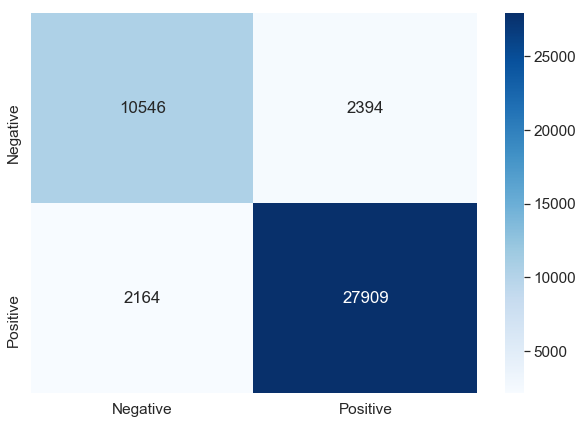

In [17]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, y_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

In [19]:
%%time

# Implementing Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

## build Random forest model
random_forest = RandomForestClassifier(n_estimators=100)

## Train the classifiers
# decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)



Wall time: 24min 24s


In [21]:
# Create Predictions
rf_pred = random_forest.predict(X_test)

In [22]:
# Check the performance of the model
print('Random Forest Model')
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Positive']))

#Graph our confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
print("Random Forest - Confusion Matrix:\n", rf_cm)

# False and True
tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
# (tn, fp, fn, tp)

print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

# Test the accuracy 
print ("\nAccuracy  score: ", round(accuracy_score(y_test, rf_pred), 2))

Random Forest Model
              precision    recall  f1-score   support

    Negative       0.98      0.73      0.84     12940
    Positive       0.90      0.99      0.94     30073

   micro avg       0.91      0.91      0.91     43013
   macro avg       0.94      0.86      0.89     43013
weighted avg       0.92      0.91      0.91     43013

Random Forest - Confusion Matrix:
 [[ 9439  3501]
 [  172 29901]]

True Negatives: 9439
False Positives: 3501
False Negatives: 172
True Positives: 29901

Accuracy  score:  0.91


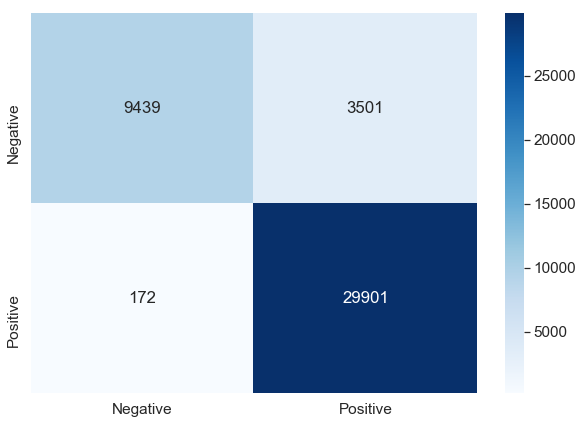

In [23]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, rf_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

<h3><strong>Save the Model</strong></h3>

In [24]:
# save the random forest model to disk
import pickle

filename = 'finalized_2cls_rf_model.sav'
pickle.dump(random_forest, open(filename, 'wb'))


In [25]:
# save the decision tree model to disk
import pickle

filename = 'finalized_2cls_dt_model.sav'
pickle.dump(clf_model, open(filename, 'wb'))


In [ ]:
# load the models from disk
clf_model = pickle.load(open('finalized_2cls_dt_model.sav', 'rb'))
random_forest = pickle.load(open('finalized_2cls_rf_model.sav', 'rb'))

<h3><strong>Run the model on new reviews</strong></h3>

In [18]:
# Let's test the model 
# Define a function to create a pipeline and run the predictions
def classify(text, classifier='None'):
    # Creating a sparse matrix 
    review_matrix = cv.transform([text])
    if classifier.lower() == 'decision tree':
        # Predict the outcome 
        y_prediction = clf_model.predict(review_matrix)
    elif classifier.lower() == 'random forest':
        y_prediction = random_forest.predict(review_matrix)
    else:
        return "Wrong/No classifier selected"       
    
    # Print the outcome
    print("Positive") if y_prediction else print("Negative")
    

In [ ]:
# Positive test #1
review = "I feel better."
# classifier = "Decision Tree"
classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Positive test #2
review = "I still have pain."
# classifier = "Decision Tree"
classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Negative test #1
review = "I feel sick."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Negative test #2
review = "I am very unhappy"
# classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)